In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
from math import sin, cos, sqrt, atan2, radians
import seaborn as sns

In [2]:
# define distance measure
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
games_rough = pd.read_csv('NCAA_Tourney_2002_2021.csv')
#games_rough.columns.values

In [4]:
games_rough1 = games_rough.copy()
games_rough1 = games_rough.query("season<2022").reset_index(drop=True)

In [5]:
games_rough1.columns.values

array(['team1_id', 'team1_score', 'team2_id', 'team2_score', 'WLoc',
       'num_ot', 'team1_position', 'team2_position', 'team1_seed',
       'team2_seed', 'strongseed', 'weakseed', 'team1_region',
       'team2_region', 'slot', 'team1_teamname', 'team2_teamname',
       'season', 'host', 'host_lat', 'host_long', 'team1_lat',
       'team1_long', 'team2_lat', 'team2_long', 'team1_coach_id',
       'team1_pt_school_ncaa', 'team1_pt_overall_ncaa',
       'team1_pt_school_s16', 'team1_pt_overall_s16',
       'team1_pt_school_ff', 'team1_pt_overall_ff',
       'team1_pt_career_school_wins', 'team1_pt_career_school_losses',
       'team1_pt_career_overall_wins', 'team1_pt_career_overall_losses',
       'team1_pt_team_season_wins', 'team1_pt_team_season_losses',
       'team1_pt_coach_season_wins', 'team1_pt_coach_season_losses',
       'team2_coach_id', 'team2_pt_school_ncaa', 'team2_pt_overall_ncaa',
       'team2_pt_school_s16', 'team2_pt_overall_s16',
       'team2_pt_school_ff', 'team2

In [6]:
# generate team distance difference
games_rough1['dist1'] = games_rough1.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
games_rough1['dist2'] = games_rough1.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [7]:
games_rough1['diff_dist'] = games_rough1['dist1'] - games_rough1['dist2']

SEED DIFFERENCE

In [8]:
# generate seed difference
games_rough1['seed_diff'] = games_rough1['team1_seed'] - games_rough1['team2_seed']

In [9]:
games_rough1['team1_win'] = (games_rough1['team1_score']>games_rough1['team2_score']).astype(int)
# print(games_rough1['team1_win'])
# games_rough1.to_csv('allvars.csv')

In [10]:
# df4heatmaps = games_rough1

# corr = df4heatmaps.corr()

# # print(corr)

# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

# corr.to_csv('all_vars.csv')

In [11]:
# generate FG% difference
# games_rough1['F2G%_diff1'] = games_rough1['team1_fg2pct'] - games_rough1['team1_oppfg2pct']
# games_rough1['F3G%_diff1'] = games_rough1['team1_fg3pct'] - games_rough1['team1_oppfg3pct']
# games_rough1['F2G%_diff2'] = games_rough1['team2_fg2pct'] - games_rough1['team2_oppfg2pct']
# games_rough1['F3G%_diff2'] = games_rough1['team2_fg3pct'] - games_rough1['team2_oppfg3pct']


games_rough1['F2G%_diff1'] = games_rough1['team1_fg2pct'] - games_rough1['team2_fg2pct']
games_rough1['F3G%_diff1'] = games_rough1['team1_fg3pct'] - games_rough1['team2_fg3pct']
games_rough1['F2G%_diff2'] = games_rough1['team1_oppfg2pct'] - games_rough1['team2_oppfg2pct']
games_rough1['F3G%_diff2'] = games_rough1['team1_oppfg3pct'] - games_rough1['team2_oppfg3pct']


FT% DIFFERENCE

In [12]:
games_rough1['FT%_diff1'] = games_rough1['team1_ftpct'] - games_rough1['team2_ftpct']
games_rough1['FT%_diff2'] = games_rough1['team1_oppftpct'] - games_rough1['team2_oppftpct']




In [13]:
games_rough1['blockpct%_diff2'] = games_rough1['team1_blockpct'] - games_rough1['team2_blockpct']
games_rough1['oppblockpct%_diff2'] = games_rough1['team1_oppblockpct'] - games_rough1['team2_oppblockpct']
games_rough1['arate%_diff2'] = games_rough1['team1_arate'] - games_rough1['team2_arate']
games_rough1['stlrate%_diff2'] = games_rough1['team1_stlrate'] - games_rough1['team2_stlrate']
games_rough1['coach_season_wins%_diff2'] = games_rough1['team1_pt_coach_season_wins'] - games_rough1['team2_pt_coach_season_wins']
games_rough1['pt_team_season_wins%_diff2'] = games_rough1['team1_pt_team_season_wins'] - games_rough1['team2_pt_team_season_wins']

In [14]:
# 'blockpct%_diff2','oppblockpct%_diff2','arate%_diff2','stlrate%_diff2'

# team1_pt_coach_season_wins  team1_pt_team_season_wins

In [15]:
# generate log odds
games_rough1['exp_win1'] = (games_rough1['team1_adjoe']**11.5)/ ((games_rough1['team1_adjde']**11.5)+(games_rough1['team1_adjoe']**11.5))
games_rough1['exp_win2'] = (games_rough1['team2_adjoe']**11.5)/ ((games_rough1['team2_adjde']**11.5)+(games_rough1['team2_adjoe']**11.5))

In [16]:
games_rough1['team1_log5'] = (games_rough1['exp_win1'] - (games_rough1['exp_win1']*games_rough1['exp_win2']))/ (games_rough1['exp_win1']+games_rough1['exp_win2']-(2*games_rough1['exp_win1']*games_rough1['exp_win2']))

In [17]:
games_rough1.dropna(subset=['team1_log5'], inplace=True)

In [18]:
training_columns = ['game_id'
                  , 'season'
                  , 'team1_win'
                  , 'exp_win2'
                  , 'exp_win1'
                  ,'team2_score'
                  ,'team1_score'
                  , 'diff_dist'
                  , 'team1_log5'
                  ,'team2_id'
                  , 'team1_id'
                  ,'seed_diff'
                  ,'F2G%_diff1'
                  ,'F3G%_diff1'
                  ,'F2G%_diff2'
                  ,'F3G%_diff2'
                  ,'FT%_diff1'
                  ,'FT%_diff2'
                 ,'blockpct%_diff2'
                  ,'oppblockpct%_diff2'
                  ,'arate%_diff2'
                  ,'stlrate%_diff2',
                 'team1_pt_coach_season_wins'
                  ,  'team1_pt_team_season_wins']
mm_data_1 = games_rough1.sample(frac=.5, random_state=15)[training_columns]
mm_data_2 = games_rough1[~games_rough1.index.isin(mm_data_1.index)][training_columns].reset_index(drop=True)
mm_data_1 = mm_data_1.reset_index(drop=True)

In [19]:
mm_data_2['team1_win'] = 0
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1


mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data_2['game_id'] = (mm_data_2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[1]
                           ) 
mm_data_2['seed_diff'] = mm_data_2['seed_diff']*-1

# mm_data_2['F2G%_diff1'] = mm_data_2['F2G%_diff1']*-1
# mm_data_2['F3G%_diff1'] = mm_data_2['F3G%_diff1']*-1
# mm_data_2['F2G%_diff2'] = mm_data_2['F2G%_diff2']*-1
# mm_data_2['F3G%_diff2'] = mm_data_2['F3G%_diff2']*-1

# mm_data_2['FT%_diff1'] = mm_data_2['FT%_diff1']*-1
# mm_data_2['FT%_diff2'] = mm_data_2['FT%_diff2']*-1

In [20]:
# dfheatmap = mm_data_2

# corr = dfheatmap.corr()

# print(corr)

# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [21]:
# mm_data_2.head()

In [22]:
# mm_data_1.columns.values

In [23]:
mm_data_2.columns = ['game_id'
                  , 'season'
                  , 'team1_win'
                  , 'exp_win2'
                  , 'exp_win1'
                  ,'team2_score'
                  ,'team1_score'
                  , 'diff_dist'
                  , 'team1_log5'
                  ,'team2_id'
                  , 'team1_id'
                  ,'seed_diff'
                  ,'F2G%_diff1'
                  ,'F3G%_diff1'
                  ,'F2G%_diff2'
                  ,'F3G%_diff2'
                  ,'FT%_diff1'
                  ,'FT%_diff2'
                 ,'blockpct%_diff2'
                  ,'oppblockpct%_diff2'
                  ,'arate%_diff2'
                  ,'stlrate%_diff2',
                 'team1_pt_coach_season_wins'
                  ,  'team1_pt_team_season_wins']

In [24]:
mm_train = pd.concat([mm_data_2, mm_data_1]).reset_index(drop=True)


In [25]:
mm_train.head(10)

,game_id,season,team1_win,exp_win2,exp_win1,team2_score,team1_score,diff_dist,team1_log5,team2_id,...,F2G%_diff2,F3G%_diff2,FT%_diff1,FT%_diff2,blockpct%_diff2,oppblockpct%_diff2,arate%_diff2,stlrate%_diff2,team1_pt_coach_season_wins,team1_pt_team_season_wins
0,2021-1166-1211,2021,0,0.925467,0.983748,65,83,-1796.211439,0.170217,1166,...,0.760847,0.349620,8.489642,-0.298732,-2.287424,-1.813540,-2.105305,0.009552,26,26
1,2021-1332-1425,2021,0,0.889608,0.936159,78,82,155.120366,0.354655,1332,...,-7.791630,0.582664,-5.728160,-3.545180,2.942403,-0.383932,1.442618,-0.040172,22,22
2,2021-1234-1332,2021,0,0.961589,0.889608,80,95,-2566.713055,0.756487,1234,...,4.222222,-1.209063,-0.863951,8.800333,-0.962626,-0.509792,-15.499356,0.031572,20,20
3,2021-1242-1425,2021,0,0.932019,0.936159,51,85,-2125.445061,0.483194,1242,...,-3.726589,1.663017,-6.684404,-0.350789,2.546985,-0.584751,-1.944774,-0.026910,22,22
4,2021-1325-1166,2021,0,0.793170,0.925467,58,72,-491.133948,0.235968,1325,...,-5.466617,-1.525455,-6.410689,-5.991650,3.703864,2.080205,-4.137245,0.008902,20,20
5,2021-1313-1211,2021,0,0.435433,0.983748,55,98,-1717.267791,0.012582,1313,...,-0.465766,0.747434,1.817894,0.993593,-3.136099,-3.031618,5.566220,0.022972,26,26
6,2021-1186-1242,2021,0,0.709120,0.932019,84,93,1865.211973,0.150970,1186,...,-1.634485,0.841740,-8.549644,0.438784,4.132791,1.637398,-1.913261,0.028479,20,20
7,2021-1364-1166,2021,0,0.821387,0.925467,62,63,2185.193284,0.270264,1364,...,-0.601277,-1.283709,-12.099131,-5.614474,2.419229,2.672602,-2.412111,-0.009839,20,20
8,2021-1179-1425,2021,0,0.850290,0.936159,56,72,-2247.308464,0.279186,1179,...,-7.527638,3.395610,-6.363242,-1.241193,5.704474,-0.035057,4.994642,-0.032780,22,22
9,2021-1281-1328,2021,0,0.865451,0.883015,68,72,-734.782772,0.460090,1281,...,-1.955422,2.636584,4.675577,2.627187,0.217596,-2.916127,-1.083591,0.010426,15,15


In [26]:
mm_train.head()

,game_id,season,team1_win,exp_win2,exp_win1,team2_score,team1_score,diff_dist,team1_log5,team2_id,...,F2G%_diff2,F3G%_diff2,FT%_diff1,FT%_diff2,blockpct%_diff2,oppblockpct%_diff2,arate%_diff2,stlrate%_diff2,team1_pt_coach_season_wins,team1_pt_team_season_wins
0,2021-1166-1211,2021,0,0.925467,0.983748,65,83,-1796.211439,0.170217,1166,...,0.760847,0.349620,8.489642,-0.298732,-2.287424,-1.813540,-2.105305,0.009552,26,26
1,2021-1332-1425,2021,0,0.889608,0.936159,78,82,155.120366,0.354655,1332,...,-7.791630,0.582664,-5.728160,-3.545180,2.942403,-0.383932,1.442618,-0.040172,22,22
2,2021-1234-1332,2021,0,0.961589,0.889608,80,95,-2566.713055,0.756487,1234,...,4.222222,-1.209063,-0.863951,8.800333,-0.962626,-0.509792,-15.499356,0.031572,20,20
3,2021-1242-1425,2021,0,0.932019,0.936159,51,85,-2125.445061,0.483194,1242,...,-3.726589,1.663017,-6.684404,-0.350789,2.546985,-0.584751,-1.944774,-0.026910,22,22
4,2021-1325-1166,2021,0,0.793170,0.925467,58,72,-491.133948,0.235968,1325,...,-5.466617,-1.525455,-6.410689,-5.991650,3.703864,2.080205,-4.137245,0.008902,20,20


In [27]:



predict_2019 = mm_train[mm_train['season']==2019].reset_index(drop=True)

In [28]:
# Prepare 2022 data for prediction

data2022 = pd.read_csv('NCAA_Tourney_2022.csv')

# print(data2022.columns.values)

In [29]:
data2022a = data2022.copy()
data2022a = data2022.query("season<2023").reset_index(drop=True)

In [30]:
data2022a['dist1'] = data2022a.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
data2022a['dist2'] = data2022a.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [31]:
data2022a['diff_dist'] = data2022a['dist1'] - data2022a['dist2']
data2022a['seed_diff'] = data2022a['team1_seed'] - data2022a['team2_seed']
data2022a['team1_win'] = 0
data2022a['team2_score'] = 0
data2022a['team1_score'] = 0

# data2022a['F2G%_diff1'] = data2022a['team1_fg2pct'] - data2022a['team1_oppfg2pct']
# data2022a['F3G%_diff1'] = data2022a['team1_fg3pct'] - data2022a['team1_oppfg3pct']
# data2022a['F2G%_diff2'] = data2022a['team2_fg2pct'] - data2022a['team2_oppfg2pct']
# data2022a['F3G%_diff2'] = data2022a['team2_fg3pct'] - data2022a['team2_oppfg3pct']

# data2022a['FT%_diff1'] = data2022a['team1_ftpct'] - data2022a['team1_oppftpct']
# data2022a['FT%_diff2'] = data2022a['team2_ftpct'] - data2022a['team2_oppftpct']


data2022a['F2G%_diff1'] = data2022a['team1_fg2pct'] - data2022a['team2_fg2pct']
data2022a['F3G%_diff1'] = data2022a['team1_fg3pct'] - data2022a['team2_fg3pct']
data2022a['F2G%_diff2'] = data2022a['team1_oppfg2pct'] - data2022a['team2_oppfg2pct']
data2022a['F3G%_diff2'] = data2022a['team1_oppfg3pct'] - data2022a['team2_oppfg3pct']

data2022a['FT%_diff1'] = data2022a['team1_ftpct'] - data2022a['team2_ftpct']
data2022a['FT%_diff2'] = data2022a['team1_oppftpct'] - data2022a['team2_oppftpct']

data2022a['blockpct%_diff2'] = data2022a['team1_blockpct'] - data2022a['team2_blockpct']
data2022a['oppblockpct%_diff2'] = data2022a['team1_oppblockpct'] - data2022a['team2_oppblockpct']
data2022a['arate%_diff2'] = data2022a['team1_arate'] - data2022a['team2_arate']
data2022a['stlrate%_diff2'] = data2022a['team1_stlrate'] - data2022a['team2_stlrate']

data2022a['coach_season_wins%_diff2'] = data2022a['team1_pt_coach_season_wins'] - data2022a['team2_pt_coach_season_wins']
data2022a['pt_team_season_wins%_diff2'] = data2022a['team1_pt_team_season_wins'] - data2022a['team2_pt_team_season_wins']


data2022a['exp_win1'] = (data2022a['team1_adjoe']**11.5)/ ((data2022a['team1_adjde']**11.5)+(data2022a['team1_adjoe']**11.5))
data2022a['exp_win2'] = (data2022a['team2_adjoe']**11.5)/ ((data2022a['team2_adjde']**11.5)+(data2022a['team2_adjoe']**11.5))

data2022a['team1_log5'] = (data2022a['exp_win1'] - (data2022a['exp_win1']*data2022a['exp_win2']))/ (data2022a['exp_win1']+data2022a['exp_win2']-(2*data2022a['exp_win1']*data2022a['exp_win2']))

data2022a.dropna(subset=['team1_log5'], inplace=True)



In [32]:
# determine columns for model training 

training_columns = ['game_id'
                    ,'season'
                    ,'team1_win'
                    ,'exp_win1'
                    ,'exp_win2'
                    ,'team2_score'
                    , 'team1_score'
                    ,'diff_dist'
                    ,'team1_log5'
                    ,'team1_id'
                    ,'team2_id'
                    ,'seed_diff'
                    ,'F2G%_diff1'
                    ,'F3G%_diff1'
                    ,'F2G%_diff2'
                    ,'F3G%_diff2'
                    ,'FT%_diff1'
                    ,'FT%_diff2','blockpct%_diff2','oppblockpct%_diff2','arate%_diff2','stlrate%_diff2',
                   'team1_pt_coach_season_wins',  'team1_pt_team_season_wins']
data_1 = data2022a.sample(frac=.5, random_state=15)[training_columns]

data_2 = data2022a[~data2022a.index.isin(data_1.index)][training_columns].reset_index(drop=True)
data_1 = data_1.reset_index(drop=True)

data_2['team1_win'] = 0
data_2['diff_dist'] = data_2['diff_dist']*-1
data_2['team1_log5'] = 1-data_2['team1_log5']
data_2['game_id'] = (data_2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + data_2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + data_2['game_id'].str.split('-', expand=True)[1]
                           ) 
data_2['seed_diff'] = data_2['seed_diff']*-1



# data_2['F2G%_diff1'] = data_2['F2G%_diff1']*-1
# data_2['F3G%_diff1'] = data_2['F3G%_diff1']*-1
# data_2['F2G%_diff2'] = data_2['F2G%_diff2']*-1
# data_2['F3G%_diff2'] = data_2['F3G%_diff2']*-1

# data_2['FT%_diff1'] = data_2['FT%_diff1']*-1
# data_2['FT%_diff2'] = data_2['FT%_diff2']*-1


data_2.columns = ['game_id'
                  , 'season'
                  , 'team1_win'
                  , 'exp_win2'
                  , 'exp_win1'
                  ,'team2_score'
                  ,'team1_score'
                  , 'diff_dist'
                  , 'team1_log5'
                  ,'team2_id'
                  , 'team1_id'
                  ,'seed_diff'
                  ,'F2G%_diff1'
                  ,'F3G%_diff1'
                  ,'F2G%_diff2'
                  ,'F3G%_diff2'
                  ,'FT%_diff1'
                  ,'FT%_diff2'
                 ,'blockpct%_diff2'
                  ,'oppblockpct%_diff2'
                  ,'arate%_diff2'
                  ,'stlrate%_diff2',
                 'team1_pt_coach_season_wins'
                  ,  'team1_pt_team_season_wins']



In [33]:
# Setup target prediction year
predict = pd.concat([data_2, data_1]).reset_index(drop=True)
predict_2022 = predict[predict['season']==2022].reset_index(drop=True)

In [34]:
# get training data
mm_train = mm_train.query("season<2021").reset_index(drop=True)

In [35]:
# Splite data
train, test = train_test_split(mm_train, train_size=.95)

In [36]:
# reset index 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [37]:
# drop variables if needed 

dropdata = [
  'game_id'
#     , 'season'
#     , 'team1_win'
#     , 'exp_win1'
#     , 'exp_win2'
    , 'team2_score'
    , 'team1_score'
#     , 'diff_dist'
#     , 'team1_log5'
    , 'team1_id'
    , 'team2_id'
#     , 'seed_diff'
#     , 'F2G%_diff1'
#     , 'F3G%_diff1'
#     , 'F2G%_diff2'
#     , 'F3G%_diff2'
#     , 'FT%_diff1'
#     , 'FT%_diff2'
#     ,'team2_coach_id'
    
]

train1 = train.drop(columns=dropdata)
test1 = test.drop(columns=dropdata)

DV = 'team1_win'
y_train = train1[DV]
X_train = train1.drop(columns=DV)
y_test = test1[DV]
X_test = test1.drop(columns=DV)


for i in train1.columns.values:
    print(i)

season
team1_win
exp_win2
exp_win1
diff_dist
team1_log5
seed_diff
F2G%_diff1
F3G%_diff1
F2G%_diff2
F3G%_diff2
FT%_diff1
FT%_diff2
blockpct%_diff2
oppblockpct%_diff2
arate%_diff2
stlrate%_diff2
team1_pt_coach_season_wins
team1_pt_team_season_wins


In [38]:
train1.head()

,season,team1_win,exp_win2,exp_win1,diff_dist,team1_log5,seed_diff,F2G%_diff1,F3G%_diff1,F2G%_diff2,F3G%_diff2,FT%_diff1,FT%_diff2,blockpct%_diff2,oppblockpct%_diff2,arate%_diff2,stlrate%_diff2,team1_pt_coach_season_wins,team1_pt_team_season_wins
0,2018,0,0.591657,0.777833,367.735937,0.292709,13,-2.338883,3.440958,-7.612722,4.747916,1.603959,-1.654981,3.952019,-1.026623,6.617211,-0.002104,25,25
1,2007,1,0.860715,0.827058,1504.668000,0.436268,-3,-4.532900,-1.278700,-2.810400,1.188700,3.370300,0.033400,4.011600,-0.115800,3.440200,-0.023100,28,28
2,2016,1,0.824468,0.889082,769.859307,0.630527,1,7.232000,-2.721700,-3.110600,-2.540100,4.966400,-2.071500,2.207300,-1.907200,-1.082800,0.012300,24,24
3,2012,1,0.784510,0.939384,561.577731,0.809770,-9,3.092600,-1.021900,-5.853200,0.766400,-1.236100,1.095500,4.490300,0.607400,-1.678000,0.009100,27,27
4,2018,1,0.659774,0.829107,216.384137,0.714435,-8,-7.582377,-0.283075,-2.857739,2.478003,-0.053694,2.672956,3.254038,2.079172,-4.235515,0.028106,24,24


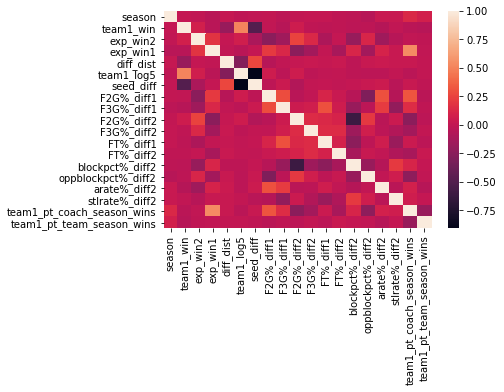

In [39]:
import seaborn as sns

df4heatmaps = train1

corr = df4heatmaps.corr()

# print(corr)

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
corr.to_csv('allvarCo.csv')

In [40]:
# find best learning rate
lrate = [0.3
         ,0.27
         ,0.26
         ,0.25
         ,0.24
         ,0.23
         ,0.2
         ,0.1
#          ,0.05
#          , 0.01
#          , 0.005
#          ,0.001
        ]

estm = [100
        , 500
        , 1000
          ]

lmd = [1
       ,2
       ,4
       ,8
    ]

for e in estm: 
    for i in lrate:
        xg_reg = xgb.XGBRegressor(objective='reg:logistic', colsample_bytree=0.9, learning_rate=i, max_depth=8,alpha = 8, n_estimators= e, reg_lambda=1)

        xg_reg1 = xgb.XGBRegressor(objective='binary:hinge', colsample_bytree=0.3, learning_rate=i, max_depth=8,alpha = 8, n_estimators= e, reg_lambda=1)

#         train model

        xg_reg.fit(X_train, y_train)
        xg_reg1.fit(X_train, y_train)

    # make prediction
        test['prob'] = xg_reg.predict(X_test)
        test['prediction'] = xg_reg.predict(X_test)
        print(f'lrate is {i},estm is {e}')
        print('log loss is ',log_loss(test['team1_win'].values, test['prob'].values),end = '\n\n')




lrate is 0.3,estm is 100
log loss is  0.26576390445737513

lrate is 0.27,estm is 100
log loss is  0.24952838967664767

lrate is 0.26,estm is 100
log loss is  0.23757442876191462

lrate is 0.25,estm is 100
log loss is  0.25317256799820115

lrate is 0.24,estm is 100
log loss is  0.24802128708589885

lrate is 0.23,estm is 100
log loss is  0.2565847218541776

lrate is 0.2,estm is 100
log loss is  0.2568237384370828

lrate is 0.1,estm is 100
log loss is  0.25478730881113115

lrate is 0.3,estm is 500
log loss is  0.26576390445737513

lrate is 0.27,estm is 500
log loss is  0.24952838967664767

lrate is 0.26,estm is 500
log loss is  0.23757442876191462

lrate is 0.25,estm is 500
log loss is  0.25317256799820115

lrate is 0.24,estm is 500
log loss is  0.24802128708589885

lrate is 0.23,estm is 500
log loss is  0.2565847218541776

lrate is 0.2,estm is 500
log loss is  0.2568237384370828

lrate is 0.1,estm is 500
log loss is  0.25478730881113115

lrate is 0.3,estm is 1000
log loss is  0.265763904

In [41]:
## set up final model
xg_reg = xgb.XGBRegressor(objective='reg:logistic', colsample_bytree=0.9, learning_rate=0.25, max_depth=8,
alpha = 8, n_estimators=3000, reg_lambda=1)

xg_reg1 = xgb.XGBRegressor(objective='binary:hinge', colsample_bytree=0.3, learning_rate=0.25, max_depth=8,
alpha = 8, n_estimators=3000, reg_lambda=1)

#train model

xg_reg.fit(X_train, y_train)
xg_reg1.fit(X_train, y_train)

# make prediction
test['prob'] = xg_reg.predict(X_test)
test['prediction'] = xg_reg1.predict(X_test)

In [42]:
test

,game_id,season,team1_win,exp_win2,exp_win1,team2_score,team1_score,diff_dist,team1_log5,team2_id,...,FT%_diff1,FT%_diff2,blockpct%_diff2,oppblockpct%_diff2,arate%_diff2,stlrate%_diff2,team1_pt_coach_season_wins,team1_pt_team_season_wins,prob,prediction
0,2006-1181-1380,2006,1,0.432869,0.940240,54,70,-1143.787407,0.953733,1380,...,11.416600,-0.408300,2.035600,1.461400,6.088900,0.018300,30,30,0.965870,1.0
1,2006-1125-1417,2006,0,0.507857,0.916590,44,78,2608.647459,0.085845,1125,...,0.058600,-0.479000,-0.888300,0.600000,0.718500,-0.015800,27,27,0.030449,0.0
2,2017-1196-1458,2017,1,0.931905,0.951229,83,84,145.711470,0.587662,1458,...,8.381159,-3.030303,2.370217,-0.745033,-4.310099,0.000433,24,24,0.826388,0.0
3,2006-1163-1246,2006,1,0.837748,0.938364,83,87,-514.433474,0.746744,1246,...,3.040900,3.630900,11.164600,-0.948300,-0.060200,0.002100,27,27,0.962318,1.0
4,2006-1133-1338,2006,1,0.907141,0.849193,66,72,-636.307446,0.365650,1338,...,2.715000,6.660200,1.219600,-1.992400,-1.551000,0.034500,20,20,0.902209,1.0
5,2013-1257-1455,2013,1,0.839693,0.966287,68,72,-733.281185,0.845488,1455,...,0.958100,-5.693600,-1.444800,-0.143200,0.169600,0.045100,29,29,0.962318,1.0
6,2006-1246-1412,2006,1,0.781418,0.837748,64,69,-424.689942,0.590884,1412,...,2.955000,-2.780200,-2.009700,1.530800,-3.781400,-0.066200,21,21,0.865160,0.0
7,2019-1251-1439,2019,0,0.765036,0.934524,58,67,105.265522,0.185750,1251,...,-2.124512,5.430318,1.268123,1.086685,6.042146,0.007821,24,24,0.030313,0.0
8,2003-1451-1458,2003,0,0.713677,0.897724,74,81,-1394.834718,0.221167,1451,...,0.024700,3.468700,5.595400,-1.408800,-3.923900,0.010400,22,22,0.033740,0.0
9,2003-1113-1272,2003,1,0.874757,0.837654,71,84,654.024787,0.424869,1272,...,1.720100,3.921700,-2.140800,1.031600,-6.039100,-0.026100,19,19,0.881323,1.0


In [43]:
# evaluate model performance 
log_loss(test['team1_win'].values, test['prob'].values)

0.25317256799820115

In [44]:
roc_auc_score(test['team1_win'].values, test['prediction'].values)

0.8122119815668203

In [45]:
accuracy_score(test['team1_win'].values, test['prediction'].values)

0.8135593220338984

In [46]:
precision_score(test['team1_win'].values, test['prediction'].values)

0.8125

In [47]:
recall_score(test['team1_win'].values, test['prediction'].values)

0.8387096774193549

In [48]:
f1_score(test['team1_win'].values, test['prediction'].values)

0.8253968253968254

In [49]:
# make prediction for 2022

# prepare new data
to_predict = predict_2022.drop(columns=dropdata)
y_test_to_predict = to_predict[DV]
X_test_to_predict = to_predict.drop(columns=DV)


In [50]:
to_predict

,season,team1_win,exp_win2,exp_win1,diff_dist,team1_log5,seed_diff,F2G%_diff1,F3G%_diff1,F2G%_diff2,F3G%_diff2,FT%_diff1,FT%_diff2,blockpct%_diff2,oppblockpct%_diff2,arate%_diff2,stlrate%_diff2,team1_pt_coach_season_wins,team1_pt_team_season_wins
0,2022,0,0.948115,0.914606,-1184.355628,0.369529,2,-2.555575,-4.901636,0.413855,-3.684451,-0.607700,-2.313412,-0.438596,0.624016,-2.891254,0.059240,26,26
1,2022,0,0.948115,0.910156,125.367544,0.356655,5,2.660764,2.223438,3.384299,-1.864167,-5.084017,3.137373,-0.587572,-1.979590,2.547208,0.008777,26,26
2,2022,0,0.948115,0.861876,-977.356425,0.254550,6,0.034700,-0.151657,-0.526316,-0.124046,0.025360,2.488745,0.107622,-3.208610,5.959844,0.012567,26,26
3,2022,0,0.948115,0.853260,1580.968271,0.241394,7,2.789424,-1.649073,1.173839,-4.983331,-7.435258,-3.612463,-0.253125,-1.154883,2.527758,0.051399,26,26
4,2022,0,0.948115,0.827679,1276.631520,0.208139,8,0.568015,-0.162593,3.301243,-1.787842,-4.912184,0.153612,-3.170265,-1.796091,-3.255018,0.018780,26,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2022,0,0.894549,0.740500,-636.842083,0.251711,7,4.427160,-1.534333,7.317601,-0.210187,-2.791874,3.650349,-10.478822,1.254938,6.032376,0.029440,22,22
2274,2022,0,0.949013,0.844849,293.181298,0.226340,8,-2.156548,2.541369,6.467875,1.688519,4.699413,4.649085,-3.877552,1.084904,0.054051,-0.049121,17,17
2275,2022,0,0.624505,0.910156,2181.758205,0.858978,-9,4.926430,-2.457282,2.056464,2.379088,6.402760,-6.536119,-4.460078,-3.841125,2.038793,0.010679,21,21
2276,2022,0,0.552079,0.974158,-3022.839708,0.968339,-15,17.797950,5.580964,-3.772154,-7.113659,1.379449,-0.508475,1.328113,-2.154004,2.779597,-0.029597,26,26


In [51]:
# make prediction
predict_2022['prob'] = xg_reg.predict(X_test_to_predict)

In [52]:
submit = predict_2022[['game_id','prob']]
submit

,game_id,prob
0,2022-1345-1124,0.678065
1,2022-1400-1124,0.771024
2,2022-1293-1124,0.848205
3,2022-1314-1124,0.905661
4,2022-1266-1124,0.915091
...,...,...
2273,2022-1350-1163,0.901329
2274,2022-1276-1403,0.916465
2275,2022-1400-1389,0.950926
2276,2022-1211-1209,0.962318


In [53]:
submit.to_csv('team_Dio‘s Bakery.csv')